In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45643")
client

<Client: 'tcp://127.0.0.1:45643' processes=2 threads=2, memory=8.00 GiB>

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import scipy.stats as sts

import os
import pickle

import SAM
import float_data as flt

import importlib
importlib.reload(SAM)
importlib.reload(flt)

from dask import delayed

In [19]:
model_folder = 'model'
n_classes = 7
ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2', 'r9i1p1f2', 'r10i1p1f2']
#ids = ['r1i1p1f2']
mask = np.load('data/mask.npy', allow_pickle=True)

Starting r1i1p1f2
Finished setup for r1i1p1f2
0


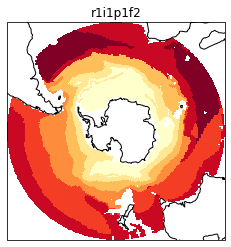

Starting r2i1p1f2
Finished setup for r2i1p1f2
0


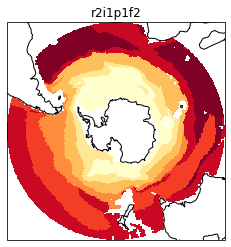

Starting r3i1p1f2
Finished setup for r3i1p1f2
0


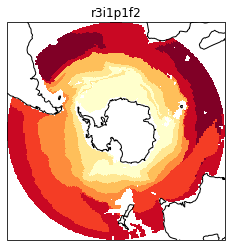

Starting r4i1p1f2
Finished setup for r4i1p1f2
0


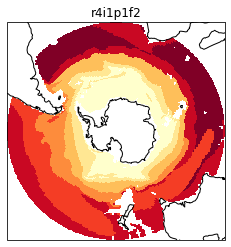

Starting r8i1p1f2
Finished setup for r8i1p1f2
0


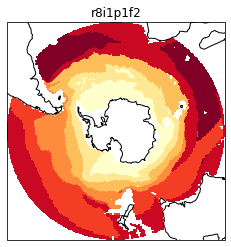

Starting r9i1p1f2
Finished setup for r9i1p1f2
0


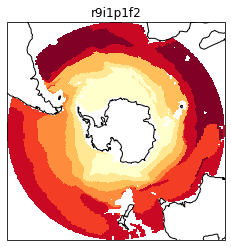

Starting r10i1p1f2
Finished setup for r10i1p1f2
0


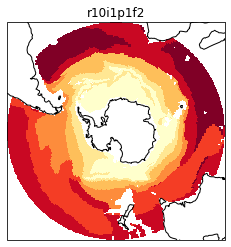

Done!


In [21]:
# Reference
avg_profiles_dict = {}
path_ref = '{}/{}/{}'.format(model_folder, ids[0], n_classes)
with open('{}/avg.obj'.format(path_ref), 'rb') as file:
  ref_profiles = pickle.load(file)
  file.close()
inds = flt.temp_sort(None, ref_profiles, True)
ref_profiles = [ref_profiles[x] for x in inds]
    
for (m_i, m_id) in enumerate(ids):

  print('Starting {}'.format(m_id))
  path_id = '{}/{}'.format(model_folder, m_id)
  path_n = '{}/{}/{}'.format(model_folder, m_id, n_classes)

  with open('{}/pca.obj'.format(path_id), 'rb') as file:
      pca = pickle.load(file)
      file.close()

  with open('{}/gmm.obj'.format(path_n), 'rb') as file:
      gmm = pickle.load(file)
      file.close()

  with open('{}/avg.obj'.format(path_n), 'rb') as file:
      avg_profiles = pickle.load(file)
      file.close()

  options = {'memberId' : m_id, 'raw' : True}
  data = flt.retrieve_profiles(timeRange = '2000-01', mask=mask, options=options)
  data_sampled = flt.normalise_data(data, ('i', 'j', 'time'))
  data_trans = flt.pca_transform(data_sampled, pca)
  data_c = flt.gmm_classify(data_trans, gmm)
  
  inds = flt.match_profiles(ref_profiles, avg_profiles)
  data_c = flt.reorder(data_c, inds).compute()
  
  avg_profiles = [avg_profiles[x] for x in inds]
  avg_profiles_dict[m_id] = avg_profiles
  print('Finished setup for {}'.format(m_id))
  
  # Make a plot
  
  lats = data_c['lat'].values
  lons = data_c['lon'].values
  lev = data['lev'].values

  plt_data = data_c.values
  alpha = np.logical_not(data.isel(time=0, lev=-1).isnull().values)
  #alpha = np.isin(data_c.isel(time=0).values, (3, 4, 5))
  plt_data[plt_data == -1] = 0
  for i in range(np.size(plt_data, 0)):
      print(i)
      ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
      ax.pcolormesh(lons, lats, plt_data[i, :, :], transform=ccrs.PlateCarree(), alpha=alpha, cmap='YlOrRd')
      ax.coastlines()
      ax.set_title(m_id)
      ax.set_facecolor('white')
      #plt.savefig('figures/{}-example'.format(m_id), dpi=600)
      plt.show()
      ax.clear()

    
print('Done!')

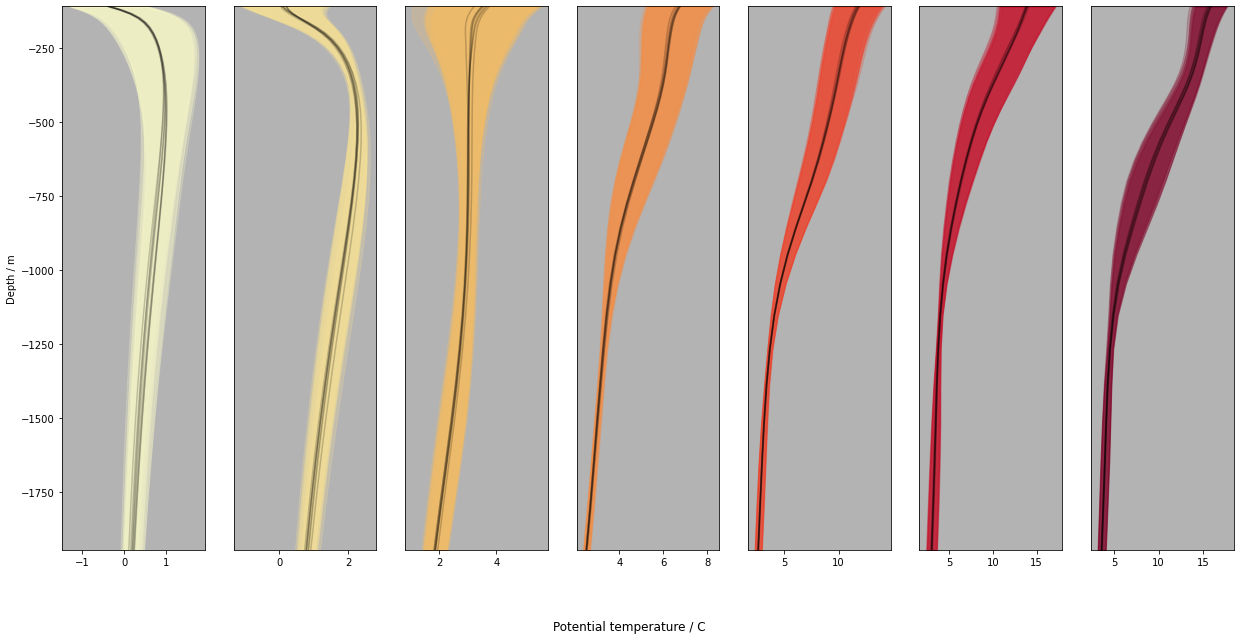

In [31]:
cmap = matplotlib.cm.get_cmap('YlOrRd')
fig, axes = plt.subplots(1, n_classes)
for (m_i, m_id) in enumerate(ids):
  for (n, ax) in enumerate(axes):
    if n > 0:
      ax.set_yticks([])
    else:
      ax.set_ylabel('Depth / m')
    ax.plot(avg_profiles_dict[m_id][n]['mean'], -lev, c='black', alpha=0.2)
    x1 = avg_profiles_dict[m_id][n]['mean'] + avg_profiles_dict[m_id][n]['std']
    x2 = avg_profiles_dict[m_id][n]['mean'] - avg_profiles_dict[m_id][n]['std']
    ax.plot(x1, -lev, c='black', ls='--', alpha=0.0)
    ax.plot(x2, -lev, c='black', ls='--', alpha=0.0)
    ax.fill_betweenx(-lev, x1, x2, color=cmap(n / (n_classes - 1)), alpha=0.2)
    
    #ax.set_xlabel('Potential temperature / C')
    ax.set_ylim(np.min(-lev), np.max(-lev))
    ax.set_facecolor((0.7, 0.7, 0.7, 1))
    
fig.supxlabel('Potential temperature / C')
fig.set_size_inches(3 * n_classes, 10)
plt.savefig('figures/profiles-example', dpi=300)